# Import all important libraries to be used in the project.
0. `os`: to navigate through the file system.
1. `torch`
2. **`nn` module:** to build the classifier.
3. **`optim` module:** to create an optimizer.
4. **`datasets` module:** to load the dataset appropriately.
5. **`transforms` module:** to apply some data augmentation to the training set and resize the images to the right dimensions to be fed to the pre-trained model.
6. **`models` module:** to load a pre-trained architecture (Transfer Learning).
7. **`matplotlib` & `seaborn` & `cv2` & `Image` module & `numpy`:** to help with visualizing the images and the prediction process.

In [34]:
# Imports here
import os
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from PIL import Image
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Visualization.

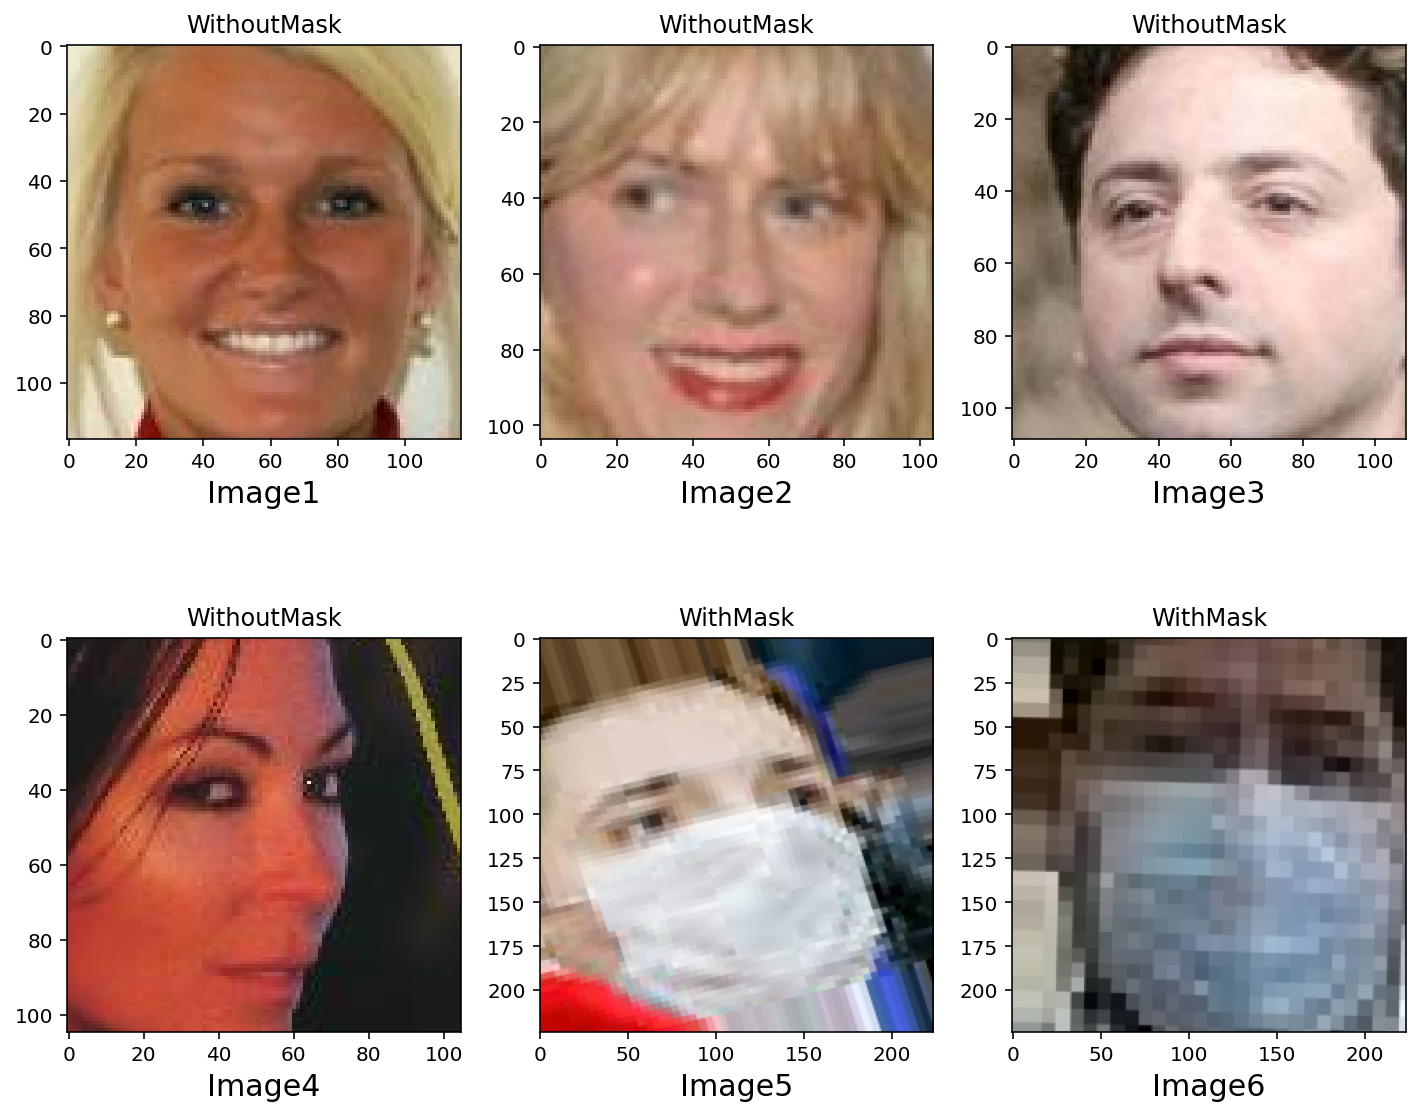

In [5]:
counter = 0   #Counter to stop ploting.
rows = 2      #Plot Rows.
columns = 3   #Plot Columns.

fig, axes= plt.subplots(rows,columns, figsize=(12,10))

for dirname,_,filenames in os.walk('/kaggle/input'):
    for filename in filenames[:4]:
        img = cv2.imread(os.path.join(dirname,filename))
        if counter < rows*columns:                  
            img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            ax = list(axes.flatten())[counter]
            ax.imshow(img)
            
            ax.set_title(dirname.split('/')[6])
            ax.set_xlabel("Image" + str(counter+1),size=15)
             
            counter +=1
plt.show()

### Setting the data paths to be used in the dataset `module`.

In [7]:
data_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'
train_dir = data_dir + '/Train'
valid_dir = data_dir + '/Validation'
test_dir = data_dir + '/Test'

### Information about the dataset.

In [14]:
print('num_of_classes: {} /'.format(len(os.listdir(train_dir))),'name_of_classes: {}'.format(os.listdir(train_dir)))
print('num_of_train_withoutmask {}/'.format(len(os.listdir(train_dir+'/WithoutMask'))),'num_of_train_withmask {}'.format(len(os.listdir(train_dir+'/WithMask'))))

print('num_of_test_withoutmask {}/'.format(len(os.listdir(test_dir+'/WithoutMask'))),'num_of_test_withmask {}'.format(len(os.listdir(test_dir+'/WithMask'))))
print('num_of_val_withoutmask {}/'.format(len(os.listdir(valid_dir+'/WithoutMask'))),'num_of_val_withmask {}'.format(len(os.listdir(valid_dir+'/WithMask'))))

num_of_classes: 2 / name_of_classes: ['WithoutMask', 'WithMask']
num_of_train_withoutmask 5000/ num_of_train_withmask 5000
num_of_test_withoutmask 509/ num_of_test_withmask 483
num_of_val_withoutmask 400/ num_of_val_withmask 400


### Create a transforms pipeline using the function `Compose` from the module `transforms`.
**Note:** we've resized the images dimensions to 224x224 to be able to feed them to the model.

**Note:** we've applied some data augmentation to the training set to help the model generalize better.

In [18]:
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])

test_transforms  = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])

### Load the data set using the `ImageFolder` function from the module `datasets` and while loading the data, we apply the transforms we've created earlier.

In [19]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset  = datasets.ImageFolder(test_dir , transform=test_transforms)

### Create iterable objects for the dataset using `torch.utils.data.DataLoader` with a batch_size of 64 splitting the data into chunks to be fed to the optimizer (mini-batch gradient descent).
**Note:** `shuffle=True`, this prevents the model from memorizing the data set.

In [20]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)
testloader  = torch.utils.data.DataLoader(test_dataset , batch_size=64)

# Build the model

### Load a pre-trained `densnet121` architecture to be used as a feature extractor using the `models` module.

In [21]:
model = models.densenet121(pretrained=True)

### Freeze all model parameters so they won't change during the training process.

In [22]:
# Freeze
for param in model.parameters():
    param.requires_grad = False

### Create a new classifier using the function `Sequential` from the module `nn`, then replace the old classifier with the new one.

In [23]:
from collections import OrderedDict
classifier = nn.Sequential(
                            OrderedDict([ ('L1', nn.Linear(1024, 512)),
                                          ('relu1', nn.ReLU()),
                                          ('Dropout1', nn.Dropout(p=0.3)),
                                          ('L2', nn.Linear(512, 256)),
                                          ('relu2', nn.ReLU()),
                                          ('Dropout2', nn.Dropout(p=0.3)),
                                          ('L3', nn.Linear(256, 2)),
                                          ('output', nn.LogSoftmax(dim=1))
                                        ])
                          )

model.classifier = classifier
model.classifier

Sequential(
  (L1): Linear(in_features=1024, out_features=512, bias=True)
  (relu1): ReLU()
  (Dropout1): Dropout(p=0.3, inplace=False)
  (L2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (Dropout2): Dropout(p=0.3, inplace=False)
  (L3): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

In [36]:
model.class_to_idx = train_dataset.class_to_idx
model.class_to_idx

{'WithMask': 0, 'WithoutMask': 1}

### Create a criterion to measure the network loss.


In [24]:
criterion = nn.NLLLoss() #Negative Log-Likelihood

### Create an optimizer to perform the weights update process.

In [42]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

### Start the Training and Validating process.

In [43]:
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, valid_losses = [], []
for epoch in range(epochs):
    
    running_loss = 0
    valid_loss = 0
    
    accuracy = 0
    
    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    else:
        
        model.eval()
        with torch.no_grad():
            for inputs, labels in validloader:
                # Move input and label tensors to the default device
                inputs, labels = inputs.to(device), labels.to(device)
                
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                
                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += batch_loss.item()
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        train_losses.append(running_loss/len(trainloader))
        valid_losses.append(valid_loss/len(validloader))
        
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Valid loss: {valid_loss/len(validloader):.3f}.. "
              f"Valid accuracy: {accuracy/len(validloader):.3f}")
        
        model.train()

Epoch 1/10.. Train loss: 0.019.. Valid loss: 0.013.. Valid accuracy: 0.995
Epoch 2/10.. Train loss: 0.050.. Valid loss: 0.031.. Valid accuracy: 0.984
Epoch 3/10.. Train loss: 0.037.. Valid loss: 0.030.. Valid accuracy: 0.988
Epoch 4/10.. Train loss: 0.034.. Valid loss: 0.010.. Valid accuracy: 0.996
Epoch 5/10.. Train loss: 0.049.. Valid loss: 0.039.. Valid accuracy: 0.983
Epoch 6/10.. Train loss: 0.068.. Valid loss: 0.016.. Valid accuracy: 0.994
Epoch 7/10.. Train loss: 0.033.. Valid loss: 0.013.. Valid accuracy: 0.994
Epoch 8/10.. Train loss: 0.038.. Valid loss: 0.015.. Valid accuracy: 0.992
Epoch 9/10.. Train loss: 0.032.. Valid loss: 0.016.. Valid accuracy: 0.993
Epoch 10/10.. Train loss: 0.031.. Valid loss: 0.015.. Valid accuracy: 0.993


### Plotting the learning curve. (Bias/Variance)

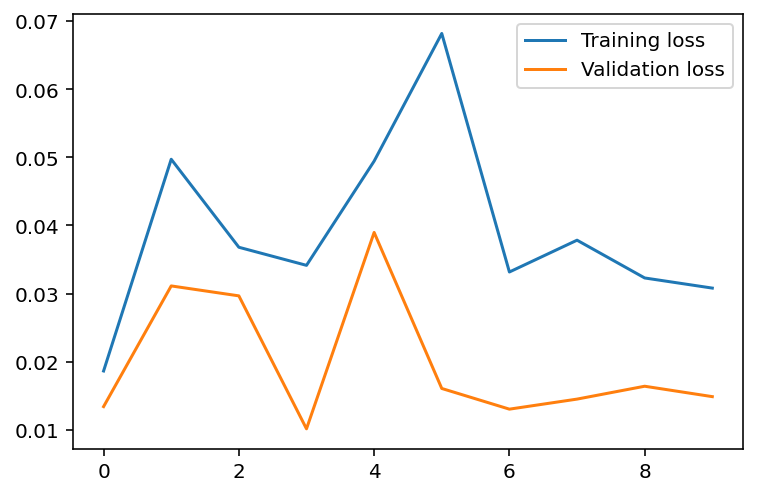

In [45]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

### Measuring the model accuracy.

In [46]:
model.eval()

test_losses, accuracies = [], []
with torch.no_grad():
    
    for inputs, labels in testloader:
        test_loss = 0
        test_accuracy = 0
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        test_losses.append(test_loss/len(testloader))
        accuracies.append(test_accuracy*100)
        
        print(f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {test_accuracy*100:.3f}%")

Test loss: 0.004.. Test accuracy: 98.438%
Test loss: 0.001.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.002.. Test accuracy: 98.438%
Test loss: 0.001.. Test accuracy: 98.438%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.000.. Test accuracy: 100.000%
Test loss: 0.003.. Test accuracy: 98.438%
Test loss: 0.001.. Test accuracy: 98.438%
Test loss: 0.000.. Test accuracy: 100.000%


In [47]:
print(f"Average Loss: {sum(test_losses)/len(test_losses):.3f}")
print(f"Average Accuracy: {sum(accuracies)/len(accuracies):.3f}%")

Average Loss: 0.001
Average Accuracy: 99.512%


# Prediction Process

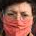

In [35]:
image = Image.open(f'{data_dir}/Test/WithMask/1163.png')
image

In [38]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    #1- store the image to be processed
    image = Image.open(image)
    
    # Convert image values to be between 0 and 1    
    image = np.array(image) / 255
    
    # Image normalization of colors
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = (image - mean)/std
    
    # Image dimensions reordering
    image = image.transpose((2, 0, 1))
    
    return image

In [39]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [40]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Proccess the input
    image = process_image(image_path)                                # Processed Image (Numpy)
    image_tensor = torch.from_numpy(image)                           # Tensor Image    (Tensor)
    image_feed = image_tensor.unsqueeze(0)                           # Add a dimension [1,3,224,224]
    
    # Go in evaluation mode
    model.eval()
    
    # Move the model to either CPU or GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():  
        model.to(device)
        image_feed.to(device)
        
        if device == 'cpu':
            logits = model.forward(image_feed.type(torch.FloatTensor))
        else:
            logits = model.forward(image_feed.type(torch.cuda.FloatTensor))
        
        ps = torch.exp(logits)
        top_p, top_class = ps.topk(topk, dim=1)
        top_p, top_class = top_p.cpu(), top_class.cpu()
        print("top class", top_class)
        
        #Invert the dictionary so you get a mapping from index to class
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}
        print(idx_to_class)
        
        top_classes = [idx_to_class[each] for each in top_class.numpy()[0]]
        print(top_classes)

    return top_p.numpy()[0].tolist(), top_classes

top class tensor([[0, 1]])
{0: 'WithMask', 1: 'WithoutMask'}
['WithMask', 'WithoutMask']


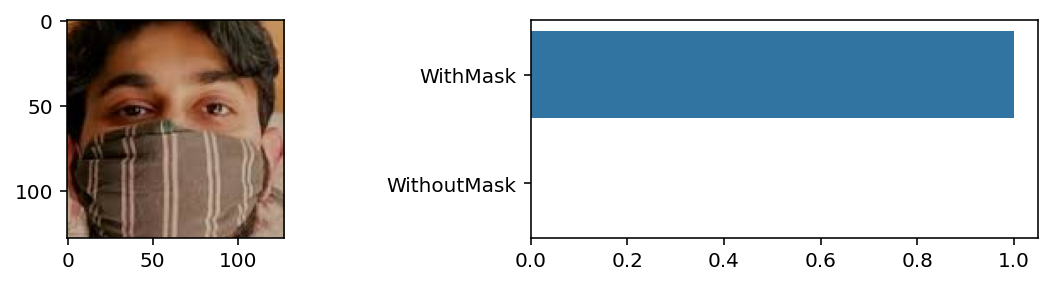

In [41]:
image_path = f'{data_dir}/Test/WithMask/1175.png'

plt.figure(figsize = (10,2))
ax = plt.subplot(1,2,1)
img = process_image(image_path)
imshow(img, ax);

probs, classes = predict(image_path, model) 
plt.subplot(1,2,2)
sb.barplot(x=probs, y=classes, color=sb.color_palette()[0]);
plt.show()

# Save/Load Process

### Create a dictionary with the various model parts to be saved using the `save` method from `torch` module. 

In [48]:
checkpoint = {
    "classifier": model.classifier,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    'class_to_idx': model.class_to_idx,
}

torch.save(checkpoint, 'checkpoint.pth')

### Write a function that loads a checkpoint and rebuilds the model using the `load` method from `torch` module.


In [49]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    # Download pretrained model
    model = models.densenet121(pretrained=True)
    
    # Freeze
    for param in model.parameters():
        param.requires_grad = False
    
    #Configure The model
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state'])
    
    #Optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
    optimizer.state = checkpoint['optimizer_state']
    
    return model, optimizer